In [1]:
# Imports
import pandas as pd
import numpy as np
import datetime
from datetime import time as dtime
from datetime import timedelta

In [2]:
# importing historical data from 2008 to 2021
SPY_Data = pd.read_csv('SPY_1min_data.csv', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Parse datetime column and divide in 2 columns
# SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
SPY_Data.rename(columns={
    'date': 'datetime'
}, inplace=True)

SPY_Data['datetime'] = pd.to_datetime(SPY_Data['datetime'])

SPY_Data['Date'] = SPY_Data['datetime'].dt.date
SPY_Data['Time'] = SPY_Data['datetime'].dt.time

# sorting the data by the time column to make sure it is consistent
SPY_Data.sort_values('datetime', inplace=True)

# Drop original 'date' column
# SPY_Data.drop(columns=['date'], inplace=True)

# Filter for regular trading hours using datetime column
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time >= pd.to_datetime("09:30").time()]
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time <= pd.to_datetime("16:00").time()]

# Making sure the order of the columns stays the same 
SPY_Data = SPY_Data[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
SPY_Data

,Date,Time,open,high,low,close,volume
0,2019-12-31,09:30:00,320.52,320.53,320.24,320.27,4255
1,2019-12-31,09:31:00,320.27,320.34,320.15,320.33,2049
2,2019-12-31,09:32:00,320.35,320.97,320.35,320.97,2953
3,2019-12-31,09:33:00,320.98,321.05,320.81,320.82,2529
4,2019-12-31,09:34:00,320.83,320.91,320.74,320.80,1373
...,...,...,...,...,...,...,...
507925,2025-08-01,15:55:00,622.10,622.29,621.64,622.25,7142
507926,2025-08-01,15:56:00,622.27,622.53,622.12,622.46,6161
507927,2025-08-01,15:57:00,622.46,622.53,622.22,622.38,7356
507928,2025-08-01,15:58:00,622.39,622.44,621.95,621.96,10144


In [5]:
# importing historical data from 2008 to 2021
SPY_Data = pd.read_csv('SPY_1min_data.csv', usecols=['date', 'open', 'high', 'low', 'close', 'volume'])

# Parse datetime column and divide in 2 columns
# SPY_Data['datetime'] = pd.to_datetime(SPY_Data['date'].str.strip(), format='%Y%m%d %H:%M:%S')
SPY_Data.rename(columns={
    'date': 'datetime'
}, inplace=True)

SPY_Data['datetime'] = pd.to_datetime(SPY_Data['datetime'])

SPY_Data['Date'] = SPY_Data['datetime'].dt.date
SPY_Data['Time'] = SPY_Data['datetime'].dt.time

# sorting the data by the time column to make sure it is consistent
SPY_Data.sort_values('datetime', inplace=True)

# Drop original 'date' column
# SPY_Data.drop(columns=['date'], inplace=True)

# Filter for regular trading hours using datetime column
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time >= pd.to_datetime("09:30").time()]
SPY_Data = SPY_Data[SPY_Data['datetime'].dt.time <= pd.to_datetime("16:00").time()]

SPY_Data_Nov2015 = SPY_Data[
    (SPY_Data['datetime'].dt.month == 11) & 
    (SPY_Data['datetime'].dt.year == 2024)
]

# Making sure the order of the columns stays the same 
SPY_Data_Nov2015 = SPY_Data_Nov2015[['Date', 'Time', 'open', 'high', 'low', 'close', 'volume']]
SPY_Data_Nov2015





,Date,Time,open,high,low,close,volume
435930,2024-11-01,09:30:00,571.32,571.45,570.70,571.38,6352
435931,2024-11-01,09:31:00,571.40,571.77,571.24,571.66,1660
435932,2024-11-01,09:32:00,571.63,571.82,571.55,571.75,897
435933,2024-11-01,09:33:00,571.79,571.91,571.63,571.88,1316
435934,2024-11-01,09:34:00,571.90,572.33,571.84,572.16,1848
...,...,...,...,...,...,...,...
443545,2024-11-29,12:55:00,602.93,602.94,602.49,602.62,3932
443546,2024-11-29,12:56:00,602.61,602.63,602.46,602.58,2646
443547,2024-11-29,12:57:00,602.59,602.59,602.42,602.50,3052
443548,2024-11-29,12:58:00,602.50,602.68,602.46,602.46,5652


In [15]:
import pandas as pd
import numpy as np

# ---- Parameters you can tweak ----
OPEN_START = "09:30:00"
OPEN_END_EXCLUSIVE = "09:35:00"   # 5-min opening range is 09:30:00–09:34:59
SESSION_END = "16:00:00"
retest_tolerance = 0.01           # how close is "touch" of boundary ($0.01)
use_close_for_breakout = True     # breakout defined by candle close beyond boundary (else use high/low pierce)
one_setup_per_day = True          # take first valid setup only per day
slippage = 0.00                   # optional per-share slippage
# ----------------------------------

def in_timerange(t, start, end):
    return (t >= pd.to_datetime(start).time()) & (t <= pd.to_datetime(end).time())

def compute_opening_range(day_df):
    mask = (day_df['Time'] >= pd.to_datetime(OPEN_START).time()) & (day_df['Time'] < pd.to_datetime(OPEN_END_EXCLUSIVE).time())
    rng = day_df.loc[mask]
    if rng.empty:
        return None, None
    return rng['high'].max(), rng['low'].min()

def first_valid_setup(day_df, highOR, lowOR):
    """
    Returns a dict describing the first valid trade of the day (or None).
    Logic:
      1) Wait for breakout (above highOR or below lowOR)
      2) Then wait for retest to boundary within tolerance
      3) Then confirmation candle:
           - Long: confirmation close > boundary after retest
           - Short: confirmation close < boundary after retest
    Entry at confirmation close. Stop at boundary. Target 2R.
    """
    # Work only after opening range is formed (>= 09:35)
    intraday = day_df[day_df['Time'] >= pd.to_datetime(OPEN_END_EXCLUSIVE).time()].copy()
    if intraday.empty:
        return None

    boundary_breached = None  # 'high' or 'low'
    boundary_level   = None
    post_breakout = False
    retest_seen = False

    def broke_high(row):
        return (row['close'] > highOR) if use_close_for_breakout else (row['high'] > highOR)

    def broke_low(row):
        return (row['close'] < lowOR) if use_close_for_breakout else (row['low'] < lowOR)

    # Step 1: detect breakout
    for i in range(len(intraday)):
        row = intraday.iloc[i]
        if broke_high(row):
            boundary_breached = 'high'
            boundary_level = highOR
            post_breakout = True
            start_idx = i + 1
            break
        if broke_low(row):
            boundary_breached = 'low'
            boundary_level = lowOR
            post_breakout = True
            start_idx = i + 1
            break

    if not post_breakout:
        return None  # no breakout

    # Step 2: wait for retest
    for j in range(start_idx, len(intraday)):
        row = intraday.iloc[j]
        touched = False
        if boundary_breached == 'high':
            # price comes back down to ~ highOR
            # consider touch if low is within tolerance of boundary
            if row['low'] <= boundary_level + retest_tolerance:
                touched = True
        else:
            # price comes back up to ~ lowOR
            if row['high'] >= boundary_level - retest_tolerance:
                touched = True

        if not retest_seen and touched:
            retest_seen = True
            # next bars will be checked for confirmation
            continue

        # Step 3: confirmation candle (the *first* candle after retest that closes away)
        if retest_seen:
            confirm = False
            direction = None
            if boundary_breached == 'high':
                # bull confirm: close back above boundary
                if row['close'] > boundary_level:
                    confirm = True
                    direction = 'long'
            else:
                # bear confirm: close back below boundary
                if row['close'] < boundary_level:
                    confirm = True
                    direction = 'short'

            if confirm:
                entry_time = intraday.index[j]
                entry_price = row['close'] + (slippage if direction == 'long' else -slippage)
                stop = boundary_level
                risk = abs(entry_price - stop)
                if risk <= 0:
                    return None
                # 2:1 reward:risk
                target = entry_price + (2 * risk) if direction == 'long' else entry_price - (2 * risk)
                return {
                    'entry_time': intraday.loc[entry_time, 'Time'],
                    'entry_dt': intraday.loc[entry_time, 'Date'],
                    'direction': direction,
                    'entry_price': entry_price,
                    'stop': stop,
                    'target': target,
                    'boundary': boundary_level
                }

    return None  # no confirmation

def simulate_trade(day_df, trade):
    """ Walk forward to 16:00 and see which hits first: stop or target; else exit MOC. """
    after_entry = day_df[(day_df['Time'] > trade['entry_time']) & (day_df['Time'] <= pd.to_datetime(SESSION_END).time())]

    exit_reason = 'MOC'
    exit_time = None
    exit_price = None

    if trade['direction'] == 'long':
        for _, r in after_entry.iterrows():
            # 1-min candle: did it hit stop or target intrabar?
            hit_stop = r['low'] <= trade['stop']
            hit_tgt  = r['high'] >= trade['target']
            if hit_stop and hit_tgt:
                # tie-breaker: assume worst (stop first). You can change to open->high/low sequencing if you store tick.
                exit_reason = 'STOP'
                exit_time = r['Time']
                exit_price = trade['stop'] - slippage
                break
            elif hit_tgt:
                exit_reason = 'TARGET'
                exit_time = r['Time']
                exit_price = trade['target'] - slippage  # sell to close
                break
            elif hit_stop:
                exit_reason = 'STOP'
                exit_time = r['Time']
                exit_price = trade['stop'] - slippage
                break
        if exit_time is None:
            # MOC
            last = after_entry.iloc[-1]
            exit_time = last['Time']
            exit_price = last['close'] - slippage
        pnl = exit_price - trade['entry_price']
    else:
        for _, r in after_entry.iterrows():
            hit_stop = r['high'] >= trade['stop']
            hit_tgt  = r['low'] <= trade['target']
            if hit_stop and hit_tgt:
                exit_reason = 'STOP'
                exit_time = r['Time']
                exit_price = trade['stop'] + slippage
                break
            elif hit_tgt:
                exit_reason = 'TARGET'
                exit_time = r['Time']
                exit_price = trade['target'] + slippage  # buy to cover
                break
            elif hit_stop:
                exit_reason = 'STOP'
                exit_time = r['Time']
                exit_price = trade['stop'] + slippage
                break
        if exit_time is None:
            last = after_entry.iloc[-1]
            exit_time = last['Time']
            exit_price = last['close'] + slippage
        pnl = trade['entry_price'] - exit_price

    r_multiple = pnl / abs(trade['entry_price'] - trade['stop'])
    return {
        'exit_time': exit_time,
        'exit_price': exit_price,
        'exit_reason': exit_reason,
        'pnl': pnl,
        'R': r_multiple
    }

# ---- Run the backtest day by day ----
def backtest_orb_retest_confirm(df):
    trades = []
    for day, day_df in df.groupby('Date'):
        # guard regular session only
        day_df = day_df.sort_values('Time')
        day_df = day_df[in_timerange(day_df['Time'], OPEN_START, SESSION_END)]

        if day_df.empty:
            continue

        highOR, lowOR = compute_opening_range(day_df)
        if highOR is None:
            continue

        setup = first_valid_setup(day_df, highOR, lowOR)
        if setup is None:
            continue

        result = simulate_trade(day_df, setup)
        trades.append({
            'date': day,
            'direction': setup['direction'],
            'entry_time': setup['entry_time'],
            'entry_price': setup['entry_price'],
            'stop': setup['stop'],
            'target': setup['target'],
            'exit_time': result['exit_time'],
            'exit_price': result['exit_price'],
            'exit_reason': result['exit_reason'],
            'pnl': result['pnl'],
            'R': result['R'],
            'open_high': highOR,
            'open_low': lowOR
        })

        if one_setup_per_day:
            continue

    trades_df = pd.DataFrame(trades)
    if trades_df.empty:
        summary = {'n_trades': 0}
        return trades_df, summary

    summary = {
        'n_trades': len(trades_df),
        'win_rate': (trades_df['R'] >= 0).mean(),
        'avg_R': trades_df['R'].mean(),
        'median_R': trades_df['R'].median(),
        'total_R': trades_df['R'].sum(),
        'avg_pnl': trades_df['pnl'].mean(),
        'total_pnl': trades_df['pnl'].sum()
    }
    return trades_df, summary

# Run it (optionally subset e.g. November 2015)
# sample filter:
# SPY_Nov2015 = SPY_Data[(pd.to_datetime(SPY_Data['Date']).dt.year == 2015) &
#                        (pd.to_datetime(SPY_Data['Date']).dt.month == 11)]
# trades, summary = backtest_orb_retest_confirm(SPY_Nov2015)

trades, summary = backtest_orb_retest_confirm(SPY_Data_Nov2015)
print(summary)
trades


{'n_trades': 18, 'win_rate': 0.2777777777777778, 'avg_R': -0.16666666666666666, 'median_R': -1.0, 'total_R': -3.0, 'avg_pnl': 0.005555555555563135, 'total_pnl': 0.10000000000013642}


,date,direction,entry_time,entry_price,stop,target,exit_time,exit_price,exit_reason,pnl,R,open_high,open_low
0,2024-11-01,long,09:40:00,572.84,572.33,573.86,10:08:00,573.86,TARGET,1.02,2.0,572.33,570.70
1,2024-11-04,short,11:38:00,570.02,570.19,569.68,11:40:00,569.68,TARGET,0.34,2.0,571.53,570.19
2,2024-11-05,long,09:44:00,572.23,572.18,572.33,09:45:00,572.18,STOP,-0.05,-1.0,572.18,570.52
3,2024-11-06,short,10:39:00,587.71,587.77,587.59,10:40:00,587.77,STOP,-0.06,-1.0,589.43,587.77
4,2024-11-07,long,09:42:00,593.80,593.56,594.28,09:43:00,593.56,STOP,-0.24,-1.0,593.56,592.99
5,2024-11-08,long,09:49:00,596.91,596.84,597.05,09:50:00,597.05,TARGET,0.14,2.0,596.84,596.16
6,2024-11-11,short,10:42:00,599.39,599.49,599.19,10:44:00,599.19,TARGET,0.20,2.0,600.13,599.49
7,2024-11-12,long,09:37:00,599.09,598.95,599.37,09:42:00,598.95,STOP,-0.14,-1.0,598.95,598.37
8,2024-11-13,long,11:25:00,597.68,597.61,597.82,11:26:00,597.61,STOP,-0.07,-1.0,597.61,597.12
9,2024-11-15,short,09:43:00,589.07,589.22,588.77,09:44:00,589.22,STOP,-0.15,-1.0,590.20,589.22


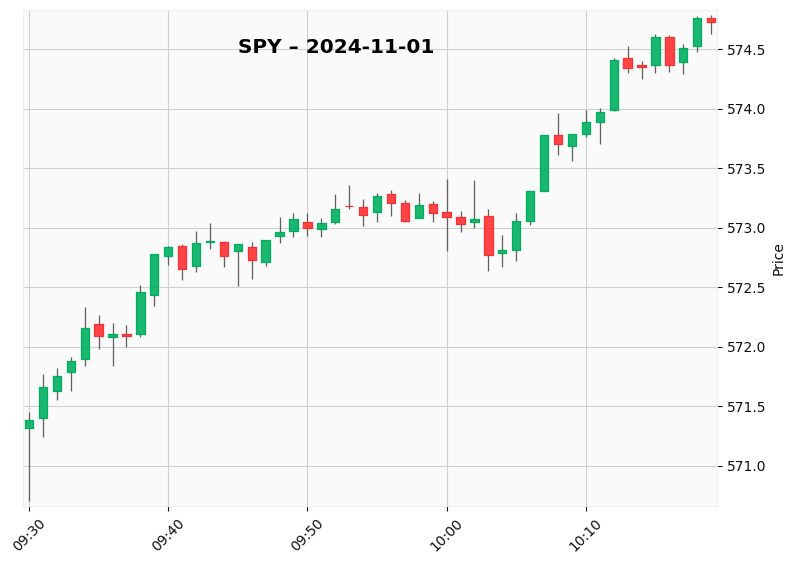

In [11]:
import pandas as pd
import mplfinance as mpf

def plot_intraday_candles(SPY_Data, date_str):
    """date_str like '2015-11-03'"""
    day = pd.to_datetime(date_str).date()
    df = SPY_Data[SPY_Data['Date'] == day].copy()
    if df.empty:
        raise ValueError(f"No rows for {day}")

    # index by a proper intraday timestamp for mplfinance
    df['ts'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df.set_index('ts', inplace=True)

    mpf.plot(
        df[['open','high','low','close']],
        type='candle',
        title=f"SPY – {day}",
        style='yahoo',       # you can try 'classic', 'charles', etc.
        datetime_format='%H:%M',
        tight_layout=True
    )

# Example:
plot_intraday_candles(SPY_Data_Nov2015[:50], '2024-11-01')


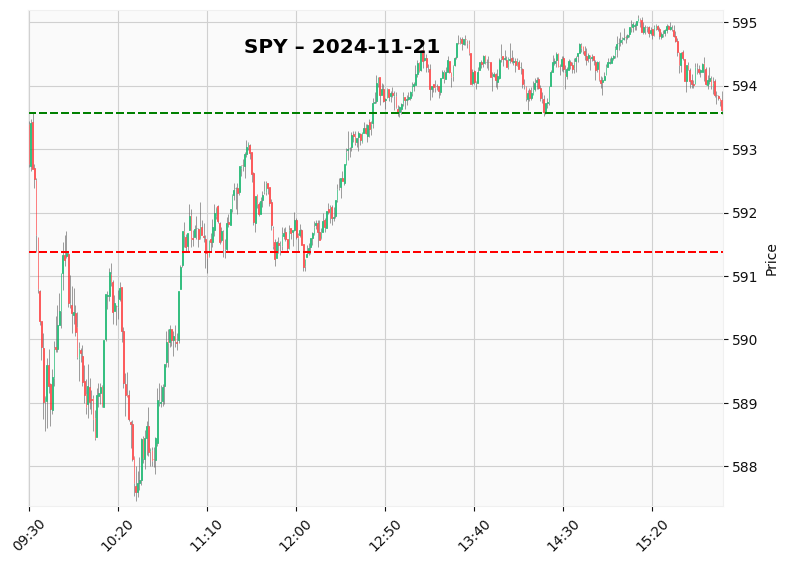

In [96]:
import pandas as pd
import mplfinance as mpf

def plot_intraday_with_opening_range(SPY_Data, date_str):
    """Plot a single day with candlesticks and mark the 5-min opening high/low."""
    day = pd.to_datetime(date_str).date()
    df = SPY_Data[SPY_Data['Date'] == day].copy()
    if df.empty:
        raise ValueError(f"No rows for {day}")

    # Build proper intraday timestamp
    df['ts'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df.set_index('ts', inplace=True)

    # Compute 5-min opening range (09:30–09:34)
    opening_mask = (df.index.time >= pd.to_datetime("09:30").time()) & (df.index.time < pd.to_datetime("09:35").time())
    open_range = df.loc[opening_mask]
    if open_range.empty:
        raise ValueError(f"No opening range found for {day}")

    highOR = open_range['high'].max()
    lowOR = open_range['low'].min()

    # Plot with horizontal lines
    mpf.plot(
        df[['open','high','low','close']],
        type='candle',
        style='yahoo',
        title=f"SPY – {day}",
        datetime_format='%H:%M',
        hlines=dict(hlines=[highOR, lowOR], colors=['g','r'], linestyle='--'),
        tight_layout=True
    )

# Example usage:
plot_intraday_with_opening_range(SPY_Data_Nov2015, '2024-11-21')


In [101]:
# ---- Parameters you can tweak ----
OPEN_START = "09:30:00"
OPEN_END_EXCLUSIVE = "09:35:00"   # 5-min opening range is 09:30:00–09:34:59
SESSION_END = "16:00:00"
retest_tolerance = 0.01           # how close is "touch" of boundary ($0.01)
use_close_for_breakout = True     # breakout defined by candle close beyond boundary (else use high/low pierce)
one_setup_per_day = True          # take first valid setup only per day
slippage = 0.00                   # optional per-share slippage
# ----------------------------------

def get_opening_range(df, date):
    day_df = df[df['Date'] == date].copy()
    mask = (day_df['Time'] >= pd.to_datetime("09:30").time()) & \
           (day_df['Time'] <  pd.to_datetime("09:35").time())
    or_data = day_df.loc[mask]
    if or_data.empty:
        return None, None
    return or_data['high'].max(), or_data['low'].min()


def get_first_breach(df, date):
    high_or, low_or = get_opening_range(df, date)
    if high_or is None:
        return None

    day_df = df[df['Date'] == date].copy()
    # only consider after OR is formed
    intraday = day_df[day_df['Time'] >= pd.to_datetime("09:35").time()]

    for _, row in intraday.iterrows():
        if row['high'] > high_or:   # breach to upside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'high',
                'OR_high': high_or,
                'OR_low': low_or,
            }
        elif row['low'] < low_or:   # breach to downside
            return {
                'Date': date,
                'timeBreach': row['Time'],
                'breach': 'low',
                'OR_high': high_or,
                'OR_low': low_or,
            }
    return None


breaches = []
for d in SPY_Data['Date'].unique():
    b = get_first_breach(SPY_Data, d)
    if b:
        breaches.append(b)

breach_df = pd.DataFrame(breaches)
breach_df




,Date,timeBreach,breach,OR_high,OR_low
0,2019-12-31,09:35:00,high,321.05,320.15
1,2020-01-02,09:35:00,high,323.86,323.41
2,2020-01-03,09:43:00,high,322.66,321.10
3,2020-01-06,09:36:00,high,321.23,320.36
4,2020-01-07,09:35:00,high,323.17,322.69
...,...,...,...,...,...
1397,2025-07-28,09:40:00,low,637.84,637.31
1398,2025-07-29,09:43:00,low,638.67,638.01
1399,2025-07-30,09:37:00,high,636.03,635.29
1400,2025-07-31,09:39:00,low,639.75,638.40


In [102]:
def get_first_retest(data_df, date, breach_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    breachInfo = breach_df[breach_df['Date'] == date].copy()
    
    high_or = breachInfo['OR_high'].iloc[0]
    low_or = breachInfo['OR_low'].iloc[0]
    timeBreach = breachInfo['timeBreach'].iloc[0]
    typeBreach = breachInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeBreach)).time()]
    
    fullBreach = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                fullBreach = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                fullBreach = True # we can start looking for a real retest now
        
        if fullBreach == True:
            if typeBreach == 'high':
                if row['low'] <= high_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
            elif typeBreach == 'low':
                if row['high'] >= low_or:   # retest
                    return {
                        'Date': date,
                        'timeBreach': timeBreach,
                        'breach': typeBreach,
                        'OR_high': high_or,
                        'OR_low': low_or,
                        'timeRetest': row['Time']
                    }
    return None


retests = []
for d in SPY_Data['Date'].unique():
    b = get_first_retest(SPY_Data, d, breach_df)
    if b:
        retests.append(b)

retests_df = pd.DataFrame(retests)
retests_df



,Date,timeBreach,breach,OR_high,OR_low,timeRetest
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00
...,...,...,...,...,...,...
1168,2025-07-28,09:40:00,low,637.84,637.31,09:51:00
1169,2025-07-29,09:43:00,low,638.67,638.01,09:57:00
1170,2025-07-30,09:37:00,high,636.03,635.29,09:47:00
1171,2025-07-31,09:39:00,low,639.75,638.40,09:45:00


In [103]:
def detectConfirmation(data_df, date, retests_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    retestInfo = retests_df[retests_df['Date'] == date].copy()
    
    high_or = retestInfo['OR_high'].iloc[0]
    low_or = retestInfo['OR_low'].iloc[0]
    timeRetest = retestInfo['timeRetest'].iloc[0]
    typeBreach = retestInfo['breach'].iloc[0]

    # only consider after first OR breach
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeRetest)).time()]
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['low'] > high_or :
                confirmationBar = True # we can start looking for a real retest now
        elif typeBreach == 'low':
            if row['high'] < low_or :
                confirmationBar = True # we can start looking for a real retest now
        
        if confirmationBar == True:
            if typeBreach == 'high':
 
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
            elif typeBreach == 'low':
                return {
                    'Date': date,
                    'timeBreach': retestInfo['timeBreach'].iloc[0],
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': row['Time']
                }
    return None


confirmationBars = []
for d in retests_df['Date'].unique():
    b = detectConfirmation(SPY_Data, d, retests_df)
    if b:
        confirmationBars.append(b)

confirmationBar_df = pd.DataFrame(confirmationBars)
confirmationBar_df

# the 12th of november has a failed outbreak to the high but it does the right pattern later in the low

,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar
0,2019-12-31,09:35:00,high,321.05,320.15,10:02:00,10:09:00
1,2020-01-02,09:35:00,high,323.86,323.41,09:47:00,15:22:00
2,2020-01-03,09:43:00,high,322.66,321.10,09:52:00,09:58:00
3,2020-01-07,09:35:00,high,323.17,322.69,11:34:00,11:35:00
4,2020-01-08,09:36:00,high,323.45,322.67,09:46:00,09:49:00
...,...,...,...,...,...,...,...
1056,2025-07-28,09:40:00,low,637.84,637.31,09:51:00,09:55:00
1057,2025-07-29,09:43:00,low,638.67,638.01,09:57:00,10:02:00
1058,2025-07-30,09:37:00,high,636.03,635.29,09:47:00,10:21:00
1059,2025-07-31,09:39:00,low,639.75,638.40,09:45:00,09:46:00


In [104]:
def runBacktest(data_df, date, confirmationBar_df):
    
    day_df = data_df[data_df['Date'] == date].copy()
    signalInfo = confirmationBar_df[confirmationBar_df['Date'] == date].copy()
    
    high_or = signalInfo['OR_high'].iloc[0]
    low_or = signalInfo['OR_low'].iloc[0]
    timeRetest = signalInfo['timeRetest'].iloc[0]
    timeConfirmationBar = signalInfo['timeConfirmationBar'].iloc[0]
    typeBreach = signalInfo['breach'].iloc[0]
    

    # only consider after confirmation candle
    intraday = day_df[day_df['Time'] > pd.to_datetime(str(timeConfirmationBar)).time()]
    
    
    # get entry price
    entryPrice = intraday.iloc[0]['open']
    
    if typeBreach == 'high':
        stopLoss = high_or - ((high_or - low_or) * 0.15)
        targetPrice = entryPrice + (entryPrice - stopLoss) * 2
    else:
        stopLoss = low_or + ((high_or - low_or) * 0.15)
        targetPrice = entryPrice - (stopLoss - entryPrice) * 2
    
    
    confirmationBar = False
    
    for _, row in intraday.iterrows():
        
        if typeBreach == 'high':
            if row['high'] >= targetPrice:
                return {
                    'Date': date,
                    'timeBreach': typeBreach,
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': row['Time'],
                    'entryPrice': entryPrice,
                    'exitPrice': targetPrice,
                    'returns':targetPrice - entryPrice
                }
            if row['low'] <= stopLoss:
                return {
                    'Date': date,
                    'timeBreach': typeBreach,
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': row['Time'],
                    'entryPrice': entryPrice,
                    'exitPrice': stopLoss,
                    'returns': stopLoss - entryPrice
                }
        elif typeBreach == 'low':
            if row['low'] <= targetPrice:
                return {
                    'Date': date,
                    'timeBreach': typeBreach,
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': row['Time'],
                    'entryPrice': entryPrice,
                    'exitPrice': targetPrice,
                    'returns':entryPrice - targetPrice
                }
            if row['high'] >= stopLoss:
                return {
                    'Date': date,
                    'timeBreach': typeBreach,
                    'breach': typeBreach,
                    'OR_high': high_or,
                    'OR_low': low_or,
                    'timeRetest': timeRetest,
                    'timeConfirmationBar': timeConfirmationBar,
                    'timeExit': row['Time'],
                    'entryPrice': entryPrice,
                    'exitPrice': stopLoss,
                    'returns':entryPrice - stopLoss
                }
        
    return None


backtest = []
for d in confirmationBar_df['Date'].unique():
    b = runBacktest(SPY_Data, d, confirmationBar_df)
    if b:
        backtest.append(b)

backtest_df = pd.DataFrame(backtest)
print(sum(backtest_df['returns']))
backtest_df

    

-36.98649999999995


,Date,timeBreach,breach,OR_high,OR_low,timeRetest,timeConfirmationBar,timeExit,entryPrice,exitPrice,returns
0,2019-12-31,high,high,321.05,320.15,10:02:00,10:09:00,10:28:00,321.13,320.9150,-0.2150
1,2020-01-02,high,high,323.86,323.41,09:47:00,15:22:00,15:50:00,323.92,324.1750,0.2550
2,2020-01-03,high,high,322.66,321.10,09:52:00,09:58:00,10:00:00,322.86,322.4260,-0.4340
3,2020-01-07,high,high,323.17,322.69,11:34:00,11:35:00,11:44:00,323.20,323.0980,-0.1020
4,2020-01-08,high,high,323.45,322.67,09:46:00,09:49:00,10:15:00,323.54,323.9540,0.4140
...,...,...,...,...,...,...,...,...,...,...,...
1043,2025-07-28,low,low,637.84,637.31,09:51:00,09:55:00,09:58:00,637.18,637.3895,-0.2095
1044,2025-07-29,low,low,638.67,638.01,09:57:00,10:02:00,10:27:00,637.92,637.5420,0.3780
1045,2025-07-30,high,high,636.03,635.29,09:47:00,10:21:00,11:03:00,636.32,635.9190,-0.4010
1046,2025-07-31,low,low,639.75,638.40,09:45:00,09:46:00,09:49:00,637.95,638.6025,-0.6525


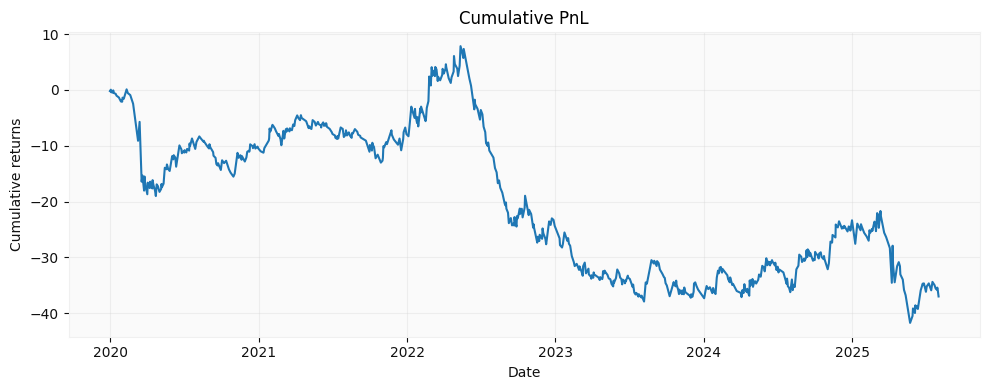

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# order by exit time if you have it; otherwise by Date
backtest_df['exit_ts'] = pd.to_datetime(
    backtest_df['Date'].astype(str) + ' ' + backtest_df['timeExit'].astype(str)
)
backtest_df = backtest_df.sort_values('exit_ts')

backtest_df['cum_pnl'] = backtest_df['returns'].cumsum()

plt.figure(figsize=(10,4))
plt.plot(backtest_df['exit_ts'], backtest_df['cum_pnl'])
plt.title('Cumulative PnL')
plt.xlabel('Date')
plt.ylabel('Cumulative returns')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


n_trades                1048.000000
win_rate                   0.315840
avg_win                    0.921082
avg_loss                  -0.476798
payoff_ratio               1.931805
expectancy_per_trade      -0.035292
gross_profit             304.878000
gross_loss               341.864500
profit_factor              0.891809
total_pnl                -36.986500
median_pnl                -0.263250
max_drawdown             -49.549500
sharpe_per_trade          -1.396103
dtype: float64


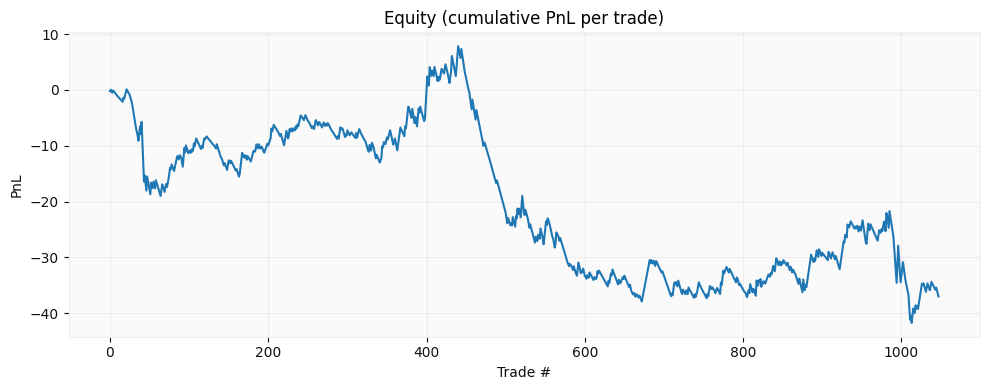

In [106]:
import numpy as np
import pandas as pd

def trade_stats(df, pnl_col='returns', r_col=None, equity_start=0.0):
    """
    df must have a PnL column (default: 'returns').
    If you also have an R-multiple column, pass its name via r_col.
    Returns (stats_dict, equity_series, drawdown_series).
    """
    # sort (optional, helps equity curve look right)
    if {'Date','timeExit'}.issubset(df.columns):
        df = df.sort_values(['Date','timeExit'])
    s = pd.Series(df[pnl_col].astype(float).values)
    n = int(s.size)
    if n == 0:
        return {}, pd.Series(dtype=float), pd.Series(dtype=float)

    wins   = s[s > 0]
    losses = s[s < 0]

    gross_profit = float(wins.sum())
    gross_loss   = float(-losses.sum())  # positive number

    win_rate  = float(len(wins) / n)
    loss_rate = float(len(losses) / n)

    avg_win  = float(wins.mean())   if len(wins)   else 0.0
    avg_loss = float(losses.mean()) if len(losses) else 0.0  # negative
    payoff   = (avg_win / abs(avg_loss)) if len(wins) and len(losses) else np.inf

    profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else np.inf
    expectancy    = win_rate * avg_win + loss_rate * avg_loss  # per trade

    equity = pd.Series(equity_start + s.cumsum(), name='equity')
    run_max = equity.cummax()
    drawdown = equity - run_max
    max_dd = float(drawdown.min())  # negative

    std = float(s.std(ddof=1))
    sharpe_per_trade = (float(s.mean()) / std * np.sqrt(n)) if std > 0 and n > 1 else np.nan

    stats = {
        'n_trades': n,
        'win_rate': win_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,                 # negative number
        'payoff_ratio': payoff,               # |avg_win| / |avg_loss|
        'expectancy_per_trade': expectancy,   # same units as returns
        'gross_profit': gross_profit,
        'gross_loss': gross_loss,
        'profit_factor': profit_factor,
        'total_pnl': float(s.sum()),
        'median_pnl': float(s.median()),
        'max_drawdown': max_dd,               # same units as returns
        'sharpe_per_trade': sharpe_per_trade
    }

    if r_col and r_col in df.columns:
        r = df[r_col].astype(float)
        stats.update({
            'avg_R': float(r.mean()),
            'median_R': float(r.median()),
            'total_R': float(r.sum()),
            'win_rate_Rpos': float((r > 0).mean())
        })

    return stats, equity, drawdown

stats, equity, dd = trade_stats(backtest_df, pnl_col='returns')  # or r_col='R' if you have it
print(pd.Series(stats))

# quick equity plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(equity.values)
plt.title('Equity (cumulative PnL per trade)')
plt.xlabel('Trade #')
plt.ylabel('PnL')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
